# Clustering evaluation on high dimensional data

Here, we explore how the higher dimensional simplices are preserved within parts of a partition. We compare the number of simplices preserved in the ground truth partition with the number preserved via Leiden.

Surprisingly, although Leiden generally yields a larger partition size - so a finer partition - than the ground truth partition, it tends to preserve a larger number of simplices. This implies that Leiden's result is not a refinement of the ground truth: it groups points differently and preserves more of the simplices structure than the ground truth.

Moreover, the Leiden partition (obtained on the kNN in high dimension) also preserves more of the low-dimensional simplices than the ground-truth partition does.

In [1]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [54]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn import cluster
from IPython.display import display, Markdown, Latex

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
from sklearn.neighbors import KNeighborsTransformer
import pynndescent

import networkx as nx
import igraph as ig
import leidenalg as la
import cdlib.algorithms as cd
import itertools
import collections
from collections import Counter
import scipy

from community import community_louvain

sns.set()

In [147]:
dataset_id = 4
set_op_mix_ratio = 1
raw_data, targets, dataset_name = get_dataset(dataset_id)
display(Markdown(f'## {dataset_name}'))
G = get_umap_graph(raw_data, dataset_id=dataset_id, set_op_mix_ratio=set_op_mix_ratio)
G = graph_edge_class_from_labels(G, targets, attribute_name = 'internal')
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)

## buildings

In [148]:
ec = la.find_partition(G, la.ModularityVertexPartition)
clustering_labels = np.array(ec.membership)
G = graph_edge_class_from_labels(G, clustering_labels, attribute_name = 'leiden_internal')
G = graph_edge_class_from_labels(G, hd_umap_labels, attribute_name = 'hdbscan_internal')

In [149]:
print(F"% external edges: {100*(1-sum(list(G.es['internal']))/G.ecount())}")
print(F"% edges cut by Leiden: {100*(1-sum(list(G.es['leiden_internal']))/G.ecount())}")
print(F"% edges cut by HDBSCAN: {100*(1-sum(list(G.es['hdbscan_internal']))/G.ecount())}")

% external edges: 24.21025375453133
% edges cut by Leiden: 7.2035214914552
% edges cut by HDBSCAN: 14.293112377006734


In [150]:
## q-based clustering
print('Ground truth: ')
print('size = ', max(targets)+1)
print('q = ',G.modularity(targets))
print('Leiden partition: ')
print('size = ', max(clustering_labels)+1)
print('q =',G.modularity(ec))
print('-----------------------')
print('HDBSCAN partition: ')
print('size = ', max(hd_umap_labels)+1)
G_sub = G.induced_subgraph([G.vs[i] for i, t in enumerate(hd_umap_labels) if t>=0])
print('q =',G_sub.modularity(hd_umap_labels[hd_umap_labels>=0]))
print('-----------------------')
print('ari =',adjusted_rand_score(targets,clustering_labels))
print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

Ground truth: 
size =  41
q =  0.7278299373437985
Leiden partition: 
size =  57
q = 0.8983111575131787
-----------------------
HDBSCAN partition: 
size =  100
q = 0.8820586602207009
-----------------------
ari = 0.2797306796636479
ami = 0.6054676911532708


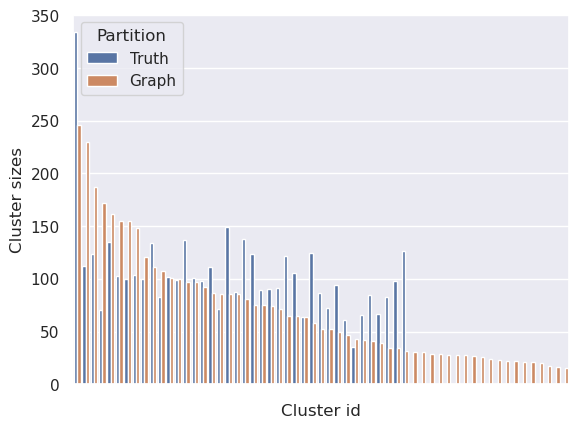

In [78]:
y1 = [k[1] for k in Counter(targets).items()]
y2 = ec.sizes()
x1 = list(range(len(y1)))
x2 = list(range(len(y2)))
df = pd.DataFrame({'Cluster sizes':y1+y2, 'Cluster id':x1+x2, 'Partition':['Truth']*len(y1)+['Graph']*len(y2)})
g = sns.barplot(data=df, x='Cluster id',y='Cluster sizes', hue='Partition')
g.set(xticklabels=[]) 
plt.savefig(F'figures/graphClust_{dataset_name}_sizes.png',bbox_inches='tight')

Ground truth: 
size =  21
q =  0.9494420801380001
Leiden partition: 
size =  49
q = 0.9579996944622434
-----------------------
ari = 0.7413482882183544
ami = 0.89578049953426


,ground_truth,cluster,1-clique_cl,2-clique_cl,3-clique_cl,4-clique_cl,5-clique_cl,1-clique_gt,2-clique_gt,3-clique_gt,4-clique_gt,5-clique_gt
0,1,12,38,72,35,0,0,72,139,67,0,0
1,1,17,34,64,31,0,0,72,139,67,0,0
2,2,27,26,41,16,0,0,72,118,47,1,0
3,2,30,25,44,21,1,0,72,118,47,1,0
4,2,33,21,30,10,0,0,72,118,47,1,0
5,3,14,36,54,19,0,0,72,110,38,0,0
6,3,15,36,54,19,0,0,72,110,38,0,0
7,4,6,49,94,46,0,0,72,140,68,0,0
8,4,32,23,43,21,0,0,72,140,68,0,0
9,5,0,72,122,38,0,0,72,122,38,0,0


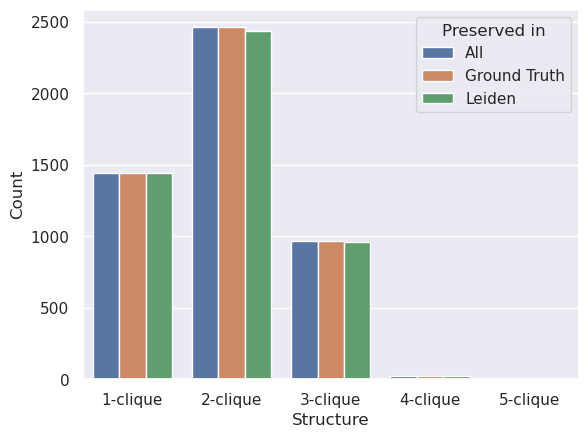

In [43]:
## q-based clustering
print('Ground truth: ')
print('size = ', max(targets)+1)
print('q = ',G.modularity(targets))
print('Leiden partition: ')
print('size = ', max(clustering_labels)+1)
print('q =',G.modularity(ec))
print('-----------------------')
print('ari =',adjusted_rand_score(targets,clustering_labels))
print('ami =',adjusted_mutual_info_score(targets,clustering_labels))

clique_per_part, clique_summary = clique_preservation(G, targets, clustering_labels)
sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
clique_per_part

## Show disagreements

<AxesSubplot:>

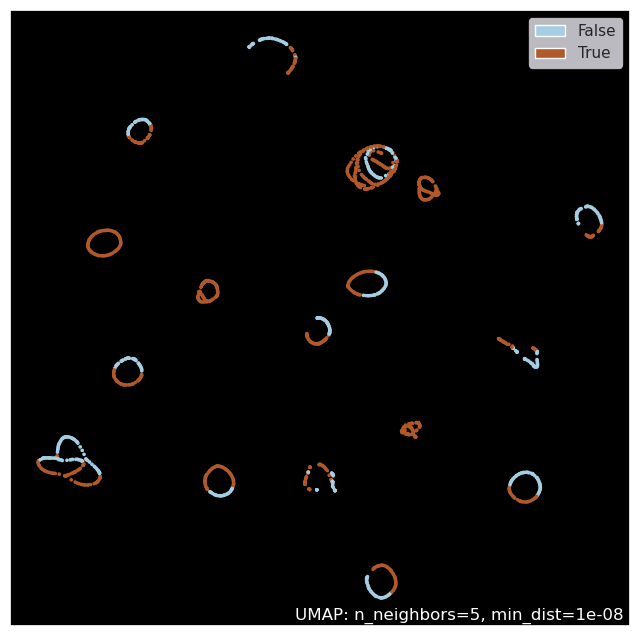

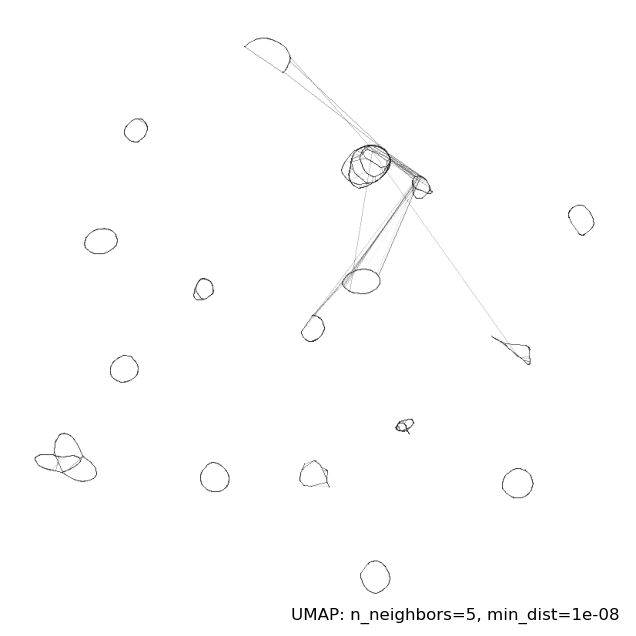

In [44]:
agree_cl_gt = clique_per_part.loc[clique_per_part.groupby(["ground_truth"])['1-clique_cl'].idxmax()]
agree_cl = np.isin(clustering_labels, list(agree_cl_gt.cluster))
present_gt = np.isin(targets, list(agree_cl_gt.ground_truth))
umap_rep = umap.UMAP(n_neighbors=5, n_components=2, min_dist=1e-8, random_state=0, n_epochs=1000).fit(raw_data)
umap.plot.points(umap_rep, labels=(agree_cl&present_gt), color_key_cmap='Paired', background='black')
umap.plot.connectivity(umap_rep, labels=(agree_cl&present_gt), color_key_cmap='Paired')

## pendigits

Ground truth: 
size =  10
q =  0.8797145712759515
Leiden partition: 
size =  27
q = 0.895541956249761
-----------------------
ari = 0.8517460969160207
ami = 0.8893509910441437


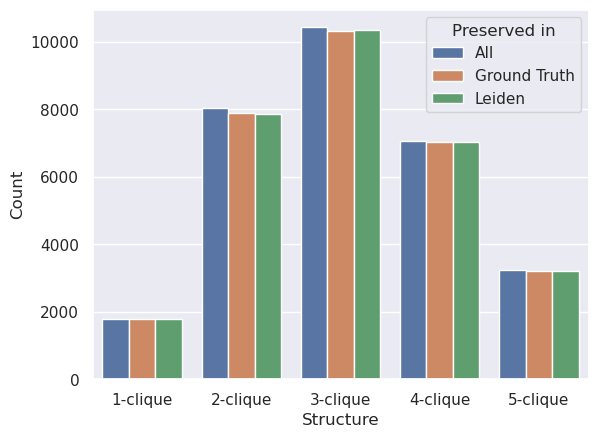

,ground_truth,cluster,1-clique_cl,2-clique_cl,3-clique_cl,4-clique_cl,5-clique_cl,1-clique_gt,2-clique_gt,3-clique_gt,4-clique_gt,5-clique_gt
0,0,3,175,689,663,276,52,178,690,663,276,52
1,0,17,2,1,0,0,0,178,690,663,276,52
2,0,26,1,0,0,0,0,178,690,663,276,52
3,1,9,87,375,527,385,168,182,839,1381,1250,711
4,1,10,70,323,537,461,228,182,839,1381,1250,711
5,1,13,28,143,322,406,315,182,839,1381,1250,711
6,1,22,1,0,0,0,0,182,839,1381,1250,711
7,2,5,166,801,1134,834,421,177,840,1195,894,458
8,2,15,10,31,53,56,36,177,840,1195,894,458
9,3,6,156,684,800,400,95,183,773,911,479,124


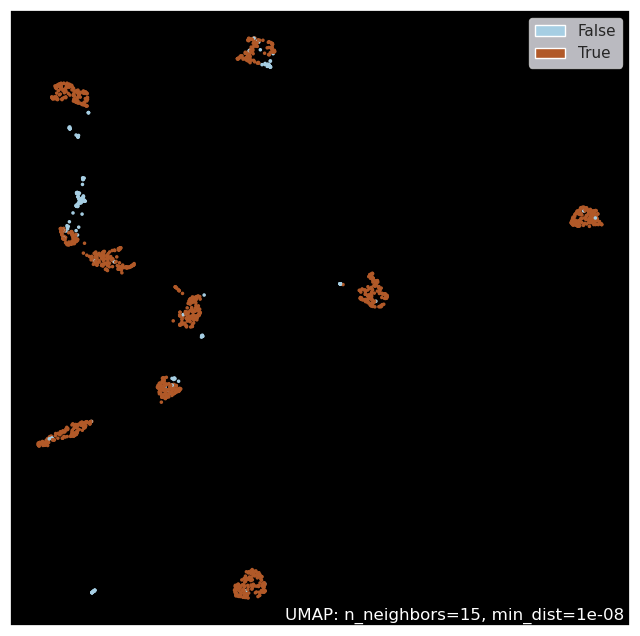

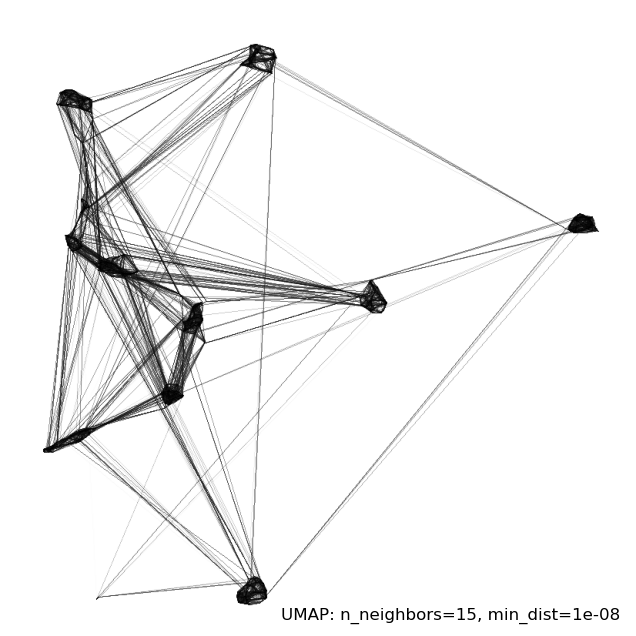

## coil

Ground truth: 
size =  21
q =  0.9494420801380001
Leiden partition: 
size =  49
q = 0.9580198216794545
-----------------------
ari = 0.741160524768101
ami = 0.8957387617027837


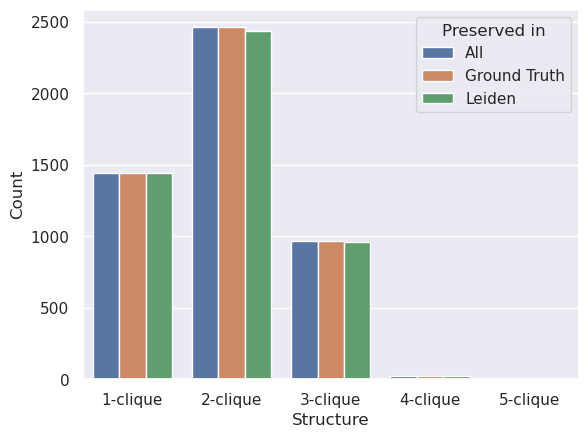

,ground_truth,cluster,1-clique_cl,2-clique_cl,3-clique_cl,4-clique_cl,5-clique_cl,1-clique_gt,2-clique_gt,3-clique_gt,4-clique_gt,5-clique_gt
0,1,10,38,72,35,0,0,72,139,67,0,0
1,1,20,34,64,31,0,0,72,139,67,0,0
2,2,29,25,39,16,1,0,72,118,47,1,0
3,2,30,25,40,16,0,0,72,118,47,1,0
4,2,33,22,36,15,0,0,72,118,47,1,0
5,3,12,38,58,21,0,0,72,110,38,0,0
6,3,17,34,50,17,0,0,72,110,38,0,0
7,4,6,49,94,46,0,0,72,140,68,0,0
8,4,32,23,43,21,0,0,72,140,68,0,0
9,5,1,72,122,38,0,0,72,122,38,0,0


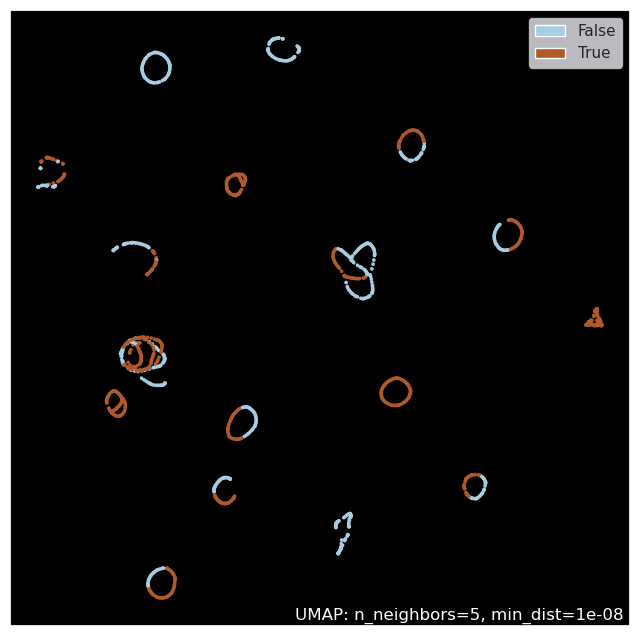

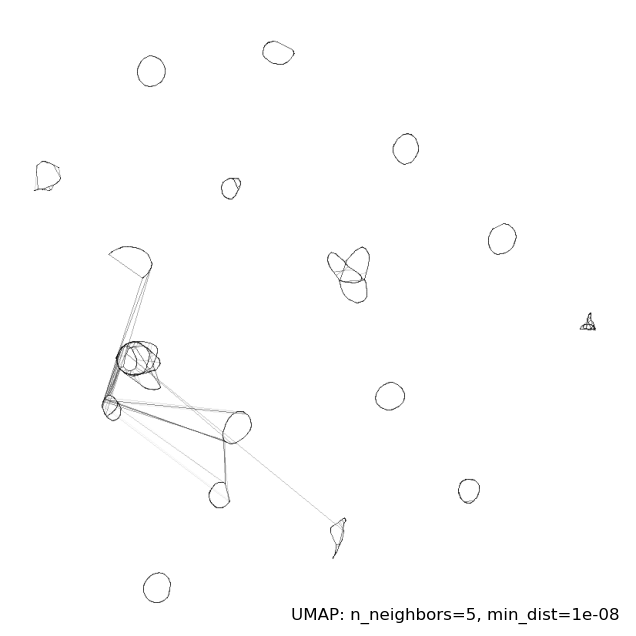

## mnist

Ground truth: 
size =  10
q =  0.8793361577356662
Leiden partition: 
size =  1968
q = 0.91502610778247
-----------------------
ari = 0.5150715866437827
ami = 0.702313724507599


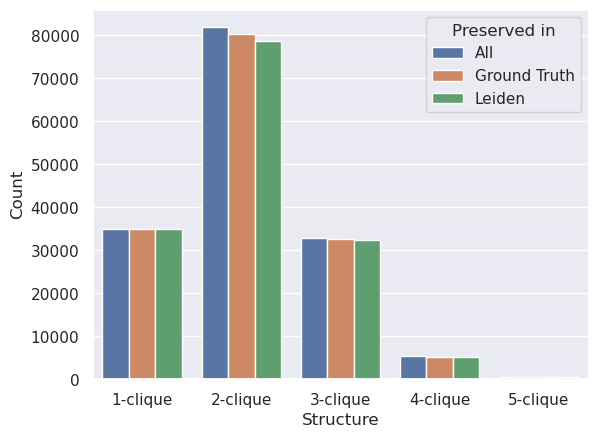

,ground_truth,cluster,1-clique_cl,2-clique_cl,3-clique_cl,4-clique_cl,5-clique_cl,1-clique_gt,2-clique_gt,3-clique_gt,4-clique_gt,5-clique_gt
0,0,7,1634,3967,1719,259,13,3434,8062,3398,505,26
1,0,9,1478,3719,1581,235,12,3434,8062,3398,505,26
2,0,29,13,14,1,0,0,3434,8062,3398,505,26
3,0,31,6,7,2,0,0,3434,8062,3398,505,26
4,0,41,4,3,0,0,0,3434,8062,3398,505,26
5,0,58,3,2,0,0,0,3434,8062,3398,505,26
6,0,60,3,2,0,0,0,3434,8062,3398,505,26
7,0,68,3,2,0,0,0,3434,8062,3398,505,26
8,0,82,2,1,0,0,0,3434,8062,3398,505,26
9,0,87,2,1,0,0,0,3434,8062,3398,505,26


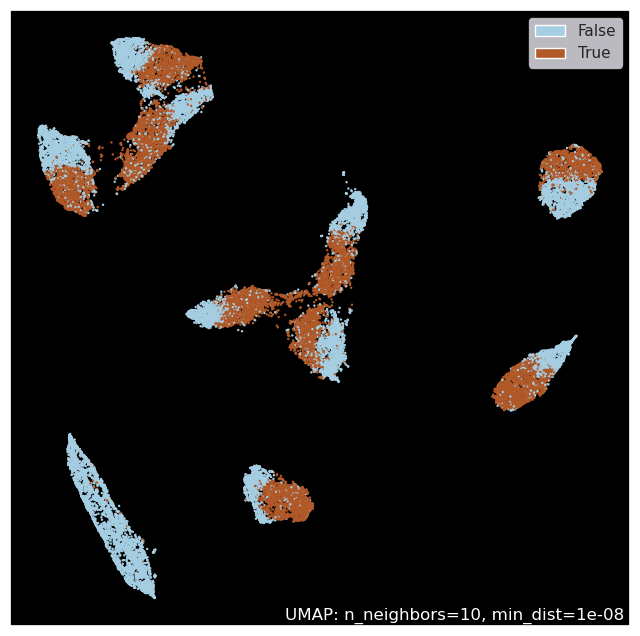

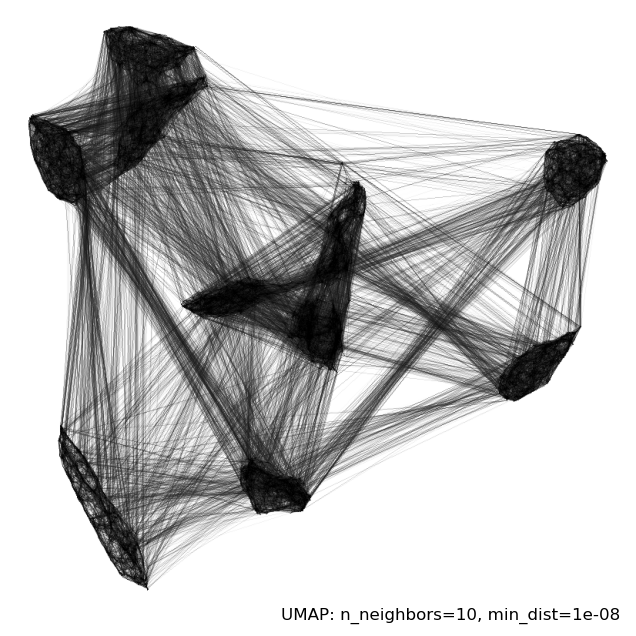

## usps

Ground truth: 
size =  11
q =  0.8757991636557155
Leiden partition: 
size =  531
q = 0.9108927935609225
-----------------------
ari = 0.5291796491211558
ami = 0.7213085891725146


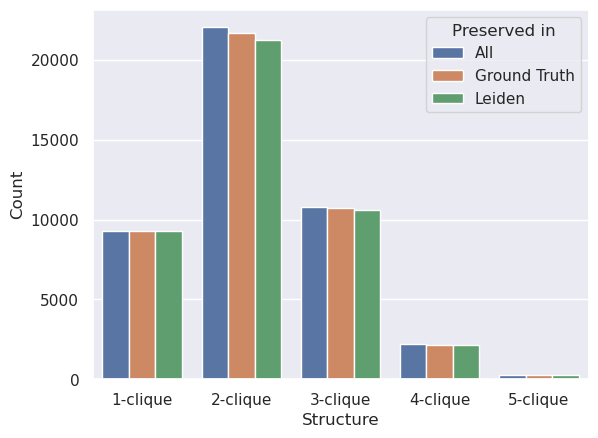

,ground_truth,cluster,1-clique_cl,2-clique_cl,3-clique_cl,4-clique_cl,5-clique_cl,1-clique_gt,2-clique_gt,3-clique_gt,4-clique_gt,5-clique_gt
0,1,9,416,1021,472,82,8,1553,3613,1759,363,48
1,1,10,406,1035,569,113,10,1553,3613,1759,363,48
2,1,12,345,732,295,45,3,1553,3613,1759,363,48
3,1,14,254,628,371,121,27,1553,3613,1759,363,48
4,1,32,5,5,1,0,0,1553,3613,1759,363,48
5,1,33,4,4,1,0,0,1553,3613,1759,363,48
6,1,36,3,3,1,0,0,1553,3613,1759,363,48
7,1,38,3,2,0,0,0,1553,3613,1759,363,48
8,1,41,3,2,0,0,0,1553,3613,1759,363,48
9,1,48,2,1,0,0,0,1553,3613,1759,363,48


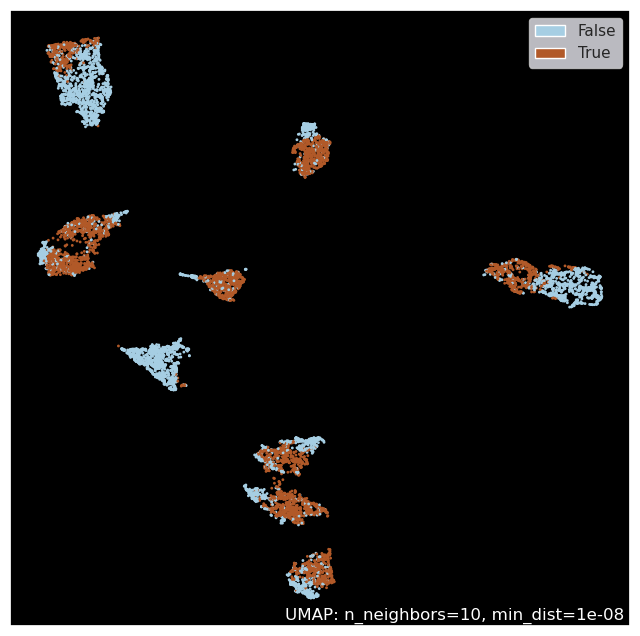

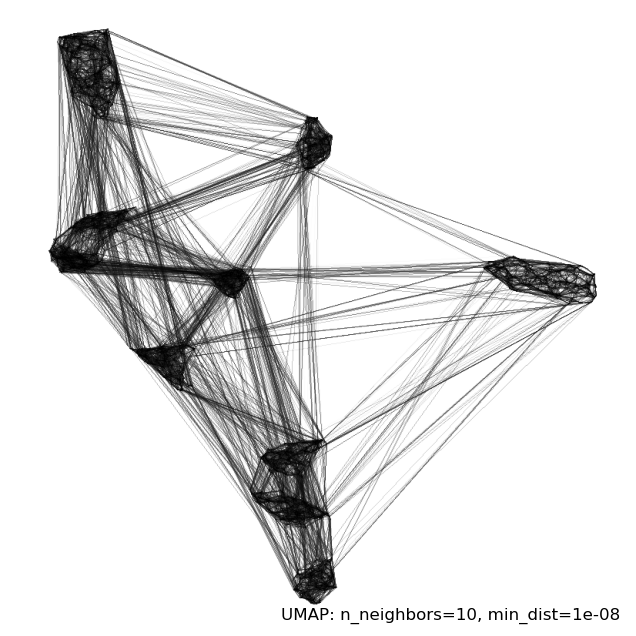

## buildings

Ground truth: 
size =  41
q =  0.947122418266131
Leiden partition: 
size =  422
q = 0.9860254260687212
-----------------------
ari = 0.36468128337432676
ami = 0.720686660639103


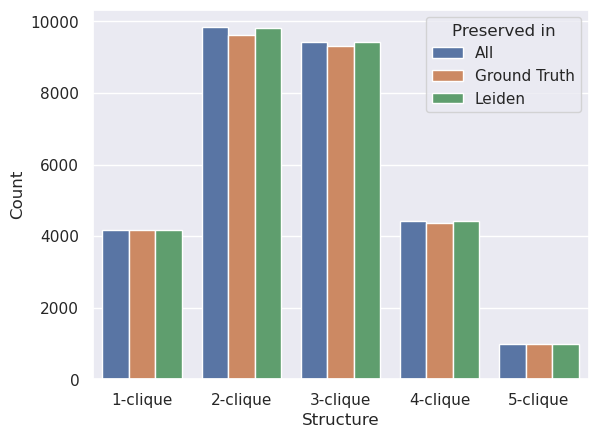

,ground_truth,cluster,1-clique_cl,2-clique_cl,3-clique_cl,4-clique_cl,5-clique_cl,1-clique_gt,2-clique_gt,3-clique_gt,4-clique_gt,5-clique_gt
0,1,0,100,296,226,50,4,334,861,735,268,56
1,1,2,82,231,180,48,2,334,861,735,268,56
2,1,19,46,108,102,57,19,334,861,735,268,56
3,1,20,45,101,83,29,4,334,861,735,268,56
4,1,34,36,102,117,69,22,334,861,735,268,56
5,1,54,27,72,71,33,8,334,861,735,268,56
6,1,122,6,8,3,0,0,334,861,735,268,56
7,1,220,1,0,0,0,0,334,861,735,268,56
8,1,221,1,0,0,0,0,334,861,735,268,56
9,1,222,1,0,0,0,0,334,861,735,268,56


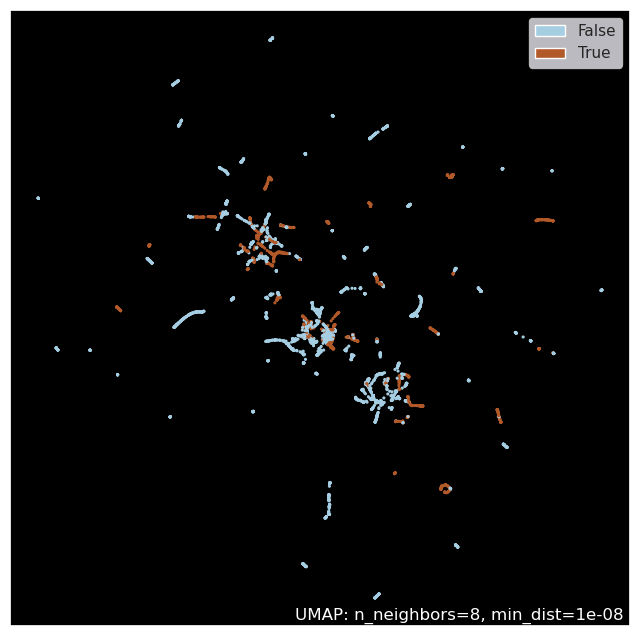

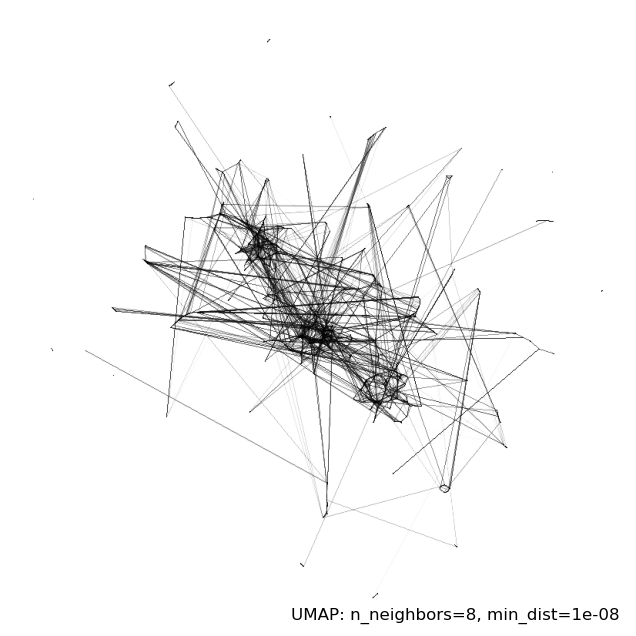

In [28]:
for dataset_id in range(5):
    G, umap_rep, clique_per_part, clique_summary, disagreement_labels = what_we_do_here(dataset_id, 0.0)
    sns.barplot(x="Structure", y="Count", hue="Preserved in", data=clique_summary)
    plt.show()
    display(clique_per_part[:20])
    umap.plot.points(umap_rep, labels=disagreement_labels, color_key_cmap='Paired', background='black')
    plt.show()
    umap.plot.connectivity(umap_rep, labels=disagreement_labels, color_key_cmap='Paired')
    plt.show()